# Transformer Model Validation and Generalization Testing

This notebook validates the trained transformer model and tests its generalization capabilities for relay optimization.

## Objectives:
1. Load and validate the trained transformer model
2. Test model performance on validation data
3. Evaluate generalization on new scenarios
4. Compare predictions with GA optimization results
5. Generate performance metrics and visualizations


In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import json
import os
import math
from pathlib import Path
from collections import defaultdict
import warnings
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import plotly.graph_objects as go
from plotly.subplots import make_subplots
warnings.filterwarnings('ignore')

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set style for plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Project configuration and directory setup
PROJECT_ROOT = Path("/Users/gustavo/Documents/Projects/TESIS_UNAL/AutoDOC-MG")
RESULTS_DIR = PROJECT_ROOT / "results"
VALIDATION_DIR = RESULTS_DIR / "validation"
GENERALIZATION_DIR = VALIDATION_DIR / "generalization"
FIGURES_DIR = GENERALIZATION_DIR / "figures"
VALIDATION_PLOTS_DIR = VALIDATION_DIR / "plots"

# Create directories if they don't exist
for directory in [VALIDATION_DIR, GENERALIZATION_DIR, FIGURES_DIR, VALIDATION_PLOTS_DIR]:
    directory.mkdir(parents=True, exist_ok=True)

print(f"📁 Created organized directory structure:")
print(f"   • Validation results: {VALIDATION_DIR}")
print(f"   • Validation plots: {VALIDATION_PLOTS_DIR}")
print(f"   • Generalization analysis: {GENERALIZATION_DIR}")
print(f"   • Figures: {FIGURES_DIR}")

# Initialize global variables for Run All compatibility
model = None
scaler_input = None
scaler_target = None
best_params = None
training_summary = None
validation_data = []
raw_data = []
ga_results = {}
predictions = None
targets = None
inputs = None
overall_metrics = {}
per_output_metrics = {}
all_test_predictions = []
test_scenarios = []

print("✅ All imports, directories, and global variables initialized")


Using device: cpu
📁 Created organized directory structure:
   • Validation results: /Users/gustavo/Documents/Projects/TESIS_UNAL/AutoDOC-MG/results/validation
   • Validation plots: /Users/gustavo/Documents/Projects/TESIS_UNAL/AutoDOC-MG/results/validation/plots
   • Generalization analysis: /Users/gustavo/Documents/Projects/TESIS_UNAL/AutoDOC-MG/results/validation/generalization
   • Figures: /Users/gustavo/Documents/Projects/TESIS_UNAL/AutoDOC-MG/results/validation/generalization/figures
✅ All imports, directories, and global variables initialized


## 1. Model Loading and Setup


In [2]:
# Transformer model architecture (same as training)
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return x

class RelayOptimizationTransformer(nn.Module):
    def __init__(self, input_dim, output_dim, d_model, nhead, num_encoder_layers, dim_feedforward, dropout=0.1):
        super(RelayOptimizationTransformer, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.d_model = d_model

        self.input_proj = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=False
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        self.output_proj = nn.Linear(d_model, output_dim)
        
        self._init_weights()

    def _init_weights(self):
        initrange = 0.1
        self.input_proj.weight.data.uniform_(-initrange, initrange)
        self.output_proj.weight.data.uniform_(-initrange, initrange)

    def forward(self, src):
        src = self.input_proj(src) * math.sqrt(self.d_model)
        src = src.permute(1, 0, 2)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src)
        output = output.permute(1, 0, 2)
        output = self.output_proj(output)
        return output

print("✅ Transformer model architecture defined")


✅ Transformer model architecture defined


In [3]:
# Configuration and paths
PROJECT_ROOT = Path("/Users/gustavo/Documents/Projects/TESIS_UNAL/AutoDOC-MG")
MODEL_DIR = PROJECT_ROOT / "models" / "transformer"  # Directory where model files are stored
RAW_DATA_PATH = PROJECT_ROOT / "data" / "raw" / "automation_results.json"
GA_RESULTS_PATH = PROJECT_ROOT / "data" / "processed" / "ga_optimization_all_scenarios_comprehensive_20251008_224215.json"

# Model files
MODEL_PATH = MODEL_DIR / "best_relay_optimization_transformer.pth"
SCALER_INPUT_PATH = MODEL_DIR / "scaler_input.pkl"
SCALER_TARGET_PATH = MODEL_DIR / "scaler_target.pkl"
BEST_PARAMS_PATH = MODEL_DIR / "best_params.json"
TRAINING_SUMMARY_PATH = MODEL_DIR / "training_summary.json"

print("📂 Configuration:")
print(f"   • Project root: {PROJECT_ROOT}")
print(f"   • Model directory: {MODEL_DIR}")
print(f"   • Raw data: {RAW_DATA_PATH}")
print(f"   • GA results: {GA_RESULTS_PATH}")

# Check if model files exist
model_files = [MODEL_PATH, SCALER_INPUT_PATH, SCALER_TARGET_PATH, BEST_PARAMS_PATH]
missing_files = [f for f in model_files if not f.exists()]

if missing_files:
    print(f"\n❌ Missing model files:")
    for f in missing_files:
        print(f"   • {f}")
    print(f"\n⚠️ Please run the training notebook first to generate these files.")
    print("📋 Steps to resolve:")
    print("   1. Open '04.transformer_optimization_training.ipynb'")
    print("   2. Execute all cells in order")
    print("   3. Wait for training to complete (this may take 30-60 minutes)")
    print("   4. Then run this validation notebook")
    print(f"\n💡 The training will create the missing model file: {MODEL_PATH}")
else:
    print(f"\n✅ All model files found!")


📂 Configuration:
   • Project root: /Users/gustavo/Documents/Projects/TESIS_UNAL/AutoDOC-MG
   • Model directory: /Users/gustavo/Documents/Projects/TESIS_UNAL/AutoDOC-MG/models/transformer
   • Raw data: /Users/gustavo/Documents/Projects/TESIS_UNAL/AutoDOC-MG/data/raw/automation_results.json
   • GA results: /Users/gustavo/Documents/Projects/TESIS_UNAL/AutoDOC-MG/data/processed/ga_optimization_all_scenarios_comprehensive_20251008_224215.json

✅ All model files found!


In [4]:
# Load model and scalers
def load_trained_model():
    """Load the trained model and scalers"""
    print("🔄 Loading trained model and scalers...")
    
    try:
        # Load scalers
        with open(SCALER_INPUT_PATH, 'rb') as f:
            scaler_input = pickle.load(f)
        with open(SCALER_TARGET_PATH, 'rb') as f:
            scaler_target = pickle.load(f)
        print("✅ Scalers loaded successfully")
    except Exception as e:
        print(f"❌ Error loading scalers: {e}")
        raise
    
    try:
        # Load best parameters
        with open(BEST_PARAMS_PATH, 'r') as f:
            best_params = json.load(f)
        print("✅ Best parameters loaded successfully")
    except Exception as e:
        print(f"❌ Error loading best parameters: {e}")
        raise
    
    try:
        # Load training summary
        if TRAINING_SUMMARY_PATH.exists():
            with open(TRAINING_SUMMARY_PATH, 'r') as f:
                training_summary = json.load(f)
            print("✅ Training summary loaded successfully")
        else:
            training_summary = None
            print("⚠️ Training summary file not found - continuing without it")
    except Exception as e:
        print(f"⚠️ Error loading training summary: {e}")
        training_summary = None
    
    try:
        # Create model
        model = RelayOptimizationTransformer(
            input_dim=6,
            output_dim=4,
            d_model=best_params['d_model'],
            nhead=best_params['nhead'],
            num_encoder_layers=best_params['num_encoder_layers'],
            dim_feedforward=best_params['dim_feedforward'],
            dropout=best_params['dropout']
        ).to(device)
        
        # Load trained weights
        model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
        model.eval()
        print("✅ Model created and weights loaded successfully")
    except Exception as e:
        print(f"❌ Error loading model: {e}")
        raise
    
    print("✅ Model and scalers loaded successfully")
    return model, scaler_input, scaler_target, best_params, training_summary

# Load everything
model, scaler_input, scaler_target, best_params, training_summary = load_trained_model()

# Display model information
print(f"\n📊 Model Information:")
print(f"   • Architecture: Transformer Encoder")
print(f"   • Input features: 6")
print(f"   • Output features: 4")
print(f"   • Model dimension: {best_params['d_model']}")
print(f"   • Number of heads: {best_params['nhead']}")
print(f"   • Encoder layers: {best_params['num_encoder_layers']}")
print(f"   • Feedforward dimension: {best_params['dim_feedforward']}")
print(f"   • Dropout: {best_params['dropout']}")
print(f"   • Total parameters: {sum(p.numel() for p in model.parameters()):,}")

if training_summary:
    # Handle different training summary structures
    if 'model_info' in training_summary:
        # New structure with model_info
        print(f"   • Training epochs: {training_summary['model_info']['training_epochs']}")
        print(f"   • Best validation loss: {training_summary['model_info']['best_validation_loss']:.6f}")
    else:
        # Current structure (direct access)
        print(f"   • Training epochs: {training_summary.get('num_final_epochs', 'Unknown')}")
        print(f"   • Best validation loss: {training_summary.get('best_val_loss', 'Unknown'):.6f}")
        print(f"   • Training mode: {training_summary.get('mode', 'Unknown')}")
        print(f"   • Training date: {training_summary.get('training_date', 'Unknown')}")


🔄 Loading trained model and scalers...
✅ Scalers loaded successfully
✅ Best parameters loaded successfully
✅ Training summary loaded successfully
✅ Model created and weights loaded successfully
✅ Model and scalers loaded successfully

📊 Model Information:
   • Architecture: Transformer Encoder
   • Input features: 6
   • Output features: 4
   • Model dimension: 64
   • Number of heads: 16
   • Encoder layers: 3
   • Feedforward dimension: 1024
   • Dropout: 0.24406387170152652
   • Total parameters: 447,876
   • Training epochs: 48
   • Best validation loss: 0.633111
   • Training mode: SINGLE_CELL_EXECUTION
   • Training date: 2025-10-10T16:07:24.f


## 2. Data Loading and Preparation


In [5]:
# Load and prepare validation data
def load_validation_data():
    """Load raw data and GA results for validation"""
    print("🔄 Loading validation data...")
    
    try:
        # Load raw data
        if RAW_DATA_PATH.exists():
            with open(RAW_DATA_PATH, 'r', encoding='utf-8') as f:
                raw_data = json.load(f)
            print("✅ Raw data loaded successfully")
        else:
            print(f"❌ Raw data file not found: {RAW_DATA_PATH}")
            raise FileNotFoundError(f"Raw data file not found: {RAW_DATA_PATH}")
    except Exception as e:
        print(f"❌ Error loading raw data: {e}")
        raise
    
    try:
        # Load GA results
        if GA_RESULTS_PATH.exists():
            with open(GA_RESULTS_PATH, 'r', encoding='utf-8') as f:
                ga_results = json.load(f)
            print("✅ GA results loaded successfully")
        else:
            print(f"❌ GA results file not found: {GA_RESULTS_PATH}")
            raise FileNotFoundError(f"GA results file not found: {GA_RESULTS_PATH}")
    except Exception as e:
        print(f"❌ Error loading GA results: {e}")
        raise
    
    print(f"📊 Data loaded:")
    print(f"   • Raw relay pairs: {len(raw_data)}")
    print(f"   • GA optimized scenarios: {len(ga_results['optimization_results'])}")
    
    return raw_data, ga_results

def create_validation_dataset(raw_data, ga_results):
    """Create validation dataset similar to training"""
    print("🔄 Creating validation dataset...")
    
    # Group raw data by scenario
    raw_by_scenario = defaultdict(list)
    for entry in raw_data:
        raw_by_scenario[entry['scenario_id']].append(entry)
    
    # Get GA results
    ga_by_scenario = ga_results['optimization_results']
    
    # Create validation dataset
    validation_data = []
    
    for scenario_id in ga_by_scenario.keys():
        if scenario_id not in raw_by_scenario:
            continue
            
        scenario_raw = raw_by_scenario[scenario_id]
        scenario_ga = ga_by_scenario[scenario_id]
        
        optimized_relays = scenario_ga['relay_values']
        
        for relay_pair in scenario_raw:
            main_relay_id = relay_pair['main_relay']['relay']
            backup_relay_id = relay_pair['backup_relay']['relay']
            
            # Check if both relays were optimized
            if main_relay_id in optimized_relays and backup_relay_id in optimized_relays:
                
                # Input features
                input_features = [
                    float(relay_pair['fault']),
                    relay_pair['main_relay']['Ishc'],
                    relay_pair['main_relay']['Time_out'],
                    relay_pair['backup_relay']['Ishc'],
                    relay_pair['backup_relay']['Time_out'],
                    len(scenario_raw)
                ]
                
                # Target features (GA optimized values)
                target_features = [
                    optimized_relays[main_relay_id]['TDS'],
                    optimized_relays[main_relay_id]['pickup'],
                    optimized_relays[backup_relay_id]['TDS'],
                    optimized_relays[backup_relay_id]['pickup']
                ]
                
                validation_data.append({
                    'scenario_id': scenario_id,
                    'input': input_features,
                    'target': target_features,
                    'main_relay': main_relay_id,
                    'backup_relay': backup_relay_id,
                    'original_pair': relay_pair
                })
    
    print(f"📊 Validation dataset created:")
    print(f"   • Validation pairs: {len(validation_data)}")
    print(f"   • Scenarios included: {len(set(d['scenario_id'] for d in validation_data))}")
    
    if len(validation_data) == 0:
        print("⚠️ WARNING: No validation data created!")
        print("   This might happen if:")
        print("   • Raw data and GA results have no matching scenarios")
        print("   • GA results don't contain optimized relay values")
        print("   • Data format is unexpected")
    
    return validation_data

# Load data
try:
    raw_data, ga_results = load_validation_data()
    validation_data = create_validation_dataset(raw_data, ga_results)
    
    if len(validation_data) == 0:
        print("\n❌ CRITICAL ERROR: No validation data available!")
        print("   Cannot proceed with validation without data.")
        print("   Please check your data files and ensure they contain matching scenarios.")
        raise ValueError("No validation data available")
        
except Exception as e:
    print(f"\n❌ Error during data loading: {e}")
    print("   Please check the data files and try again.")
    raise


🔄 Loading validation data...
✅ Raw data loaded successfully
✅ GA results loaded successfully
📊 Data loaded:
   • Raw relay pairs: 6800
   • GA optimized scenarios: 68
🔄 Creating validation dataset...
📊 Validation dataset created:
   • Validation pairs: 6732
   • Scenarios included: 68


## 3. Model Validation and Performance Metrics


In [6]:
# Validation function
def validate_model(model, validation_data, scaler_input, scaler_target):
    """Validate the model on validation data"""
    print("🔄 Validating model...")
    
    if model is None:
        raise ValueError("Model not loaded. Please run the model loading cell first.")
    
    if len(validation_data) == 0:
        raise ValueError("No validation data available. Please run the data loading cell first.")
    
    predictions = []
    targets = []
    inputs = []
    
    model.eval()
    
    with torch.no_grad():
        for i, item in enumerate(validation_data):
            # Prepare input
            input_features = np.array(item['input']).reshape(1, -1)
            target_features = np.array(item['target'])
            
            # Normalize input
            input_normalized = scaler_input.transform(input_features)
            
            # Convert to tensor
            input_tensor = torch.tensor(input_normalized, dtype=torch.float32).unsqueeze(0).to(device)
            
            # Make prediction
            prediction = model(input_tensor)
            prediction_np = prediction.cpu().numpy().reshape(-1, 4)[0]
            
            # Denormalize prediction
            prediction_denorm = scaler_target.inverse_transform([prediction_np])[0]
            
            # Store results
            predictions.append(prediction_denorm)
            targets.append(target_features)
            inputs.append(input_features.flatten())
            
            if (i + 1) % 100 == 0:
                print(f"   Processed {i + 1}/{len(validation_data)} samples")
    
    predictions = np.array(predictions)
    targets = np.array(targets)
    inputs = np.array(inputs)
    
    print(f"✅ Validation completed: {len(predictions)} samples processed")
    
    return predictions, targets, inputs

# Run validation
try:
    predictions, targets, inputs = validate_model(model, validation_data, scaler_input, scaler_target)
    print("✅ Validation step completed successfully")
except Exception as e:
    print(f"❌ Error during validation: {e}")
    raise


🔄 Validating model...
   Processed 100/6732 samples
   Processed 200/6732 samples
   Processed 300/6732 samples
   Processed 400/6732 samples
   Processed 500/6732 samples
   Processed 600/6732 samples
   Processed 700/6732 samples
   Processed 800/6732 samples
   Processed 900/6732 samples
   Processed 1000/6732 samples
   Processed 1100/6732 samples
   Processed 1200/6732 samples
   Processed 1300/6732 samples
   Processed 1400/6732 samples
   Processed 1500/6732 samples
   Processed 1600/6732 samples
   Processed 1700/6732 samples
   Processed 1800/6732 samples
   Processed 1900/6732 samples
   Processed 2000/6732 samples
   Processed 2100/6732 samples
   Processed 2200/6732 samples
   Processed 2300/6732 samples
   Processed 2400/6732 samples
   Processed 2500/6732 samples
   Processed 2600/6732 samples
   Processed 2700/6732 samples
   Processed 2800/6732 samples
   Processed 2900/6732 samples
   Processed 3000/6732 samples
   Processed 3100/6732 samples
   Processed 3200/6732 sam

In [7]:
# Calculate performance metrics
def calculate_metrics(predictions, targets):
    """Calculate comprehensive performance metrics"""
    
    # Overall metrics
    mse = mean_squared_error(targets, predictions)
    mae = mean_absolute_error(targets, predictions)
    r2 = r2_score(targets, predictions)
    
    # Per-output metrics
    output_names = ['Main_TDS', 'Main_Pickup', 'Backup_TDS', 'Backup_Pickup']
    metrics = {}
    
    for i, name in enumerate(output_names):
        mse_i = mean_squared_error(targets[:, i], predictions[:, i])
        mae_i = mean_absolute_error(targets[:, i], predictions[:, i])
        r2_i = r2_score(targets[:, i], predictions[:, i])
        
        # Calculate percentage errors
        mape_i = np.mean(np.abs((targets[:, i] - predictions[:, i]) / targets[:, i])) * 100
        
        metrics[name] = {
            'MSE': mse_i,
            'MAE': mae_i,
            'R2': r2_i,
            'MAPE': mape_i,
            'RMSE': np.sqrt(mse_i)
        }
    
    # Overall metrics
    overall_metrics = {
        'Overall_MSE': mse,
        'Overall_MAE': mae,
        'Overall_R2': r2,
        'Overall_RMSE': np.sqrt(mse)
    }
    
    return overall_metrics, metrics

# Calculate metrics
overall_metrics, per_output_metrics = calculate_metrics(predictions, targets)

# Display results
print("📊 MODEL PERFORMANCE METRICS")
print("=" * 60)
print(f"Overall Performance:")
for metric, value in overall_metrics.items():
    print(f"   • {metric}: {value:.6f}")

print(f"\nPer-Output Performance:")
for output, metrics in per_output_metrics.items():
    print(f"\n   {output}:")
    for metric, value in metrics.items():
        if metric == 'MAPE':
            print(f"     • {metric}: {value:.2f}%")
        else:
            print(f"     • {metric}: {value:.6f}")

# Calculate additional statistics
prediction_errors = predictions - targets
print(f"\n📈 ERROR STATISTICS:")
print(f"   • Mean absolute error: {np.mean(np.abs(prediction_errors)):.6f}")
print(f"   • Max absolute error: {np.max(np.abs(prediction_errors)):.6f}")
print(f"   • Error standard deviation: {np.std(prediction_errors):.6f}")
print(f"   • Error range: [{np.min(prediction_errors):.6f}, {np.max(prediction_errors):.6f}]")


📊 MODEL PERFORMANCE METRICS
Overall Performance:
   • Overall_MSE: 0.043612
   • Overall_MAE: 0.141402
   • Overall_R2: 0.376310
   • Overall_RMSE: 0.208834

Per-Output Performance:

   Main_TDS:
     • MSE: 0.034158
     • MAE: 0.154705
     • R2: 0.033101
     • MAPE: 61.42%
     • RMSE: 0.184819

   Main_Pickup:
     • MSE: 0.052124
     • MAE: 0.135742
     • R2: 0.664756
     • MAPE: 58.75%
     • RMSE: 0.228307

   Backup_TDS:
     • MSE: 0.033995
     • MAE: 0.154394
     • R2: 0.020990
     • MAPE: 56.45%
     • RMSE: 0.184378

   Backup_Pickup:
     • MSE: 0.054170
     • MAE: 0.120766
     • R2: 0.786395
     • MAPE: 53.99%
     • RMSE: 0.232744

📈 ERROR STATISTICS:
   • Mean absolute error: 0.141402
   • Max absolute error: 3.473062
   • Error standard deviation: 0.208307
   • Error range: [-1.757642, 3.473062]


## 4. Visualization and Analysis


📊 Creating validation visualizations...


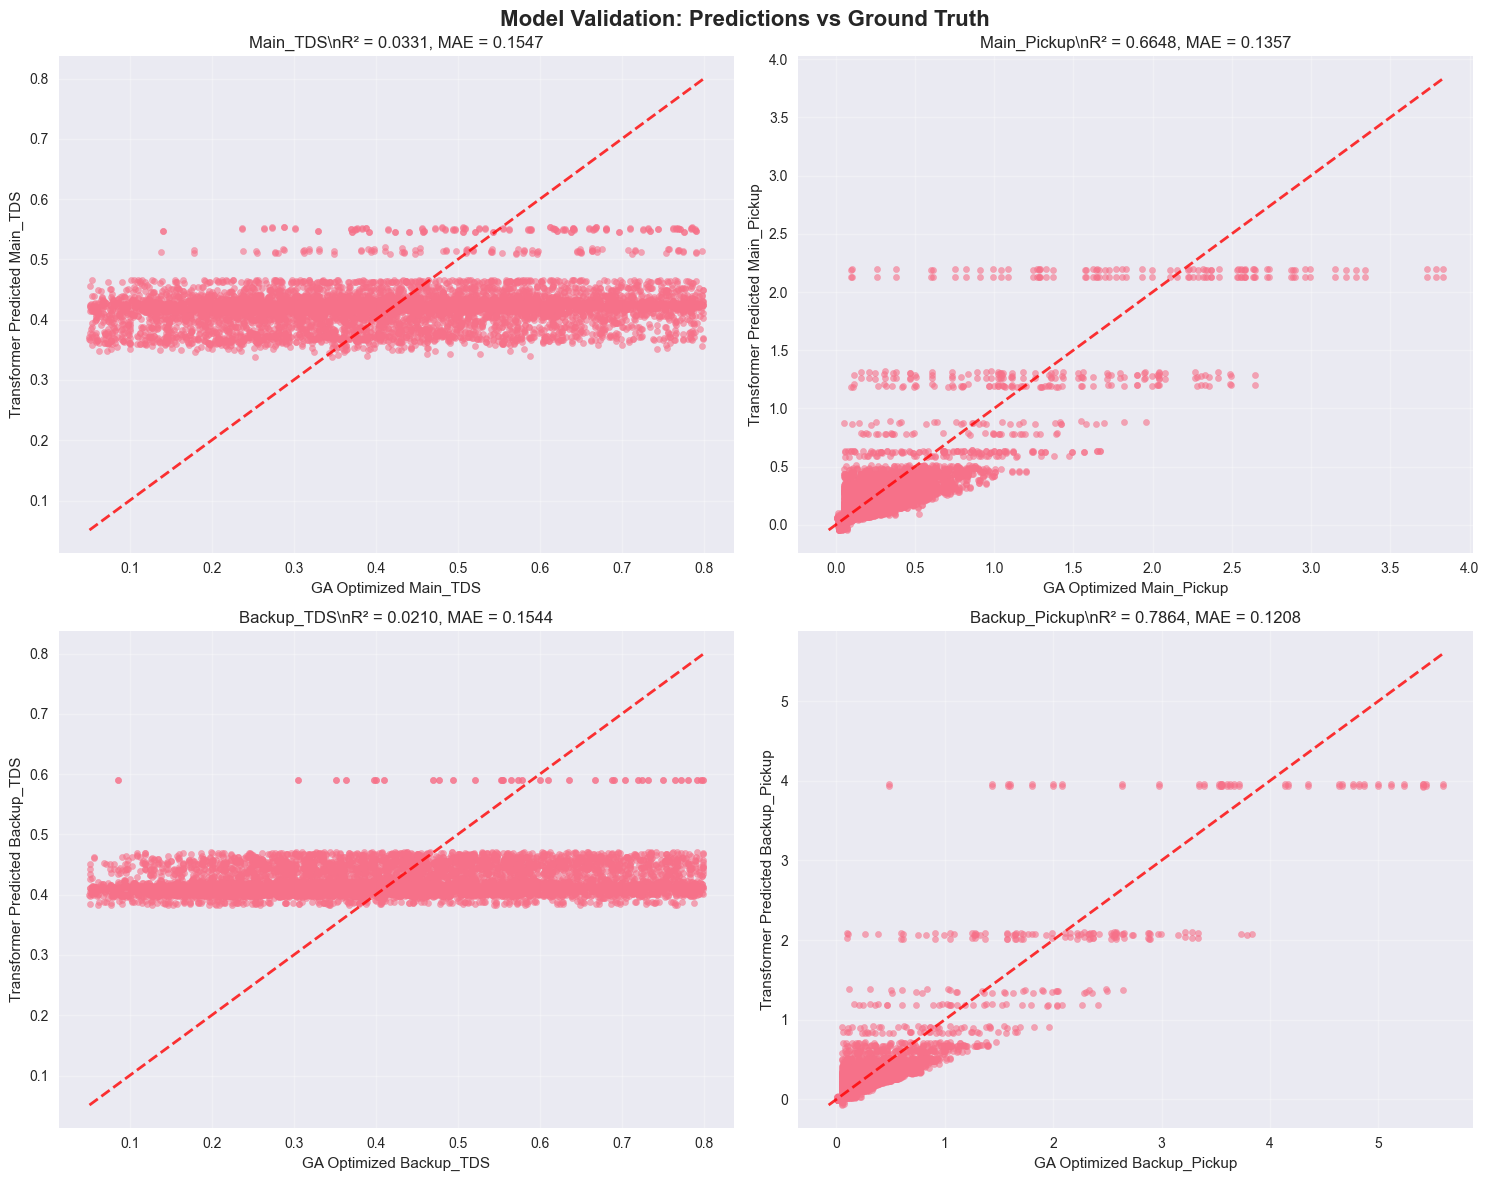

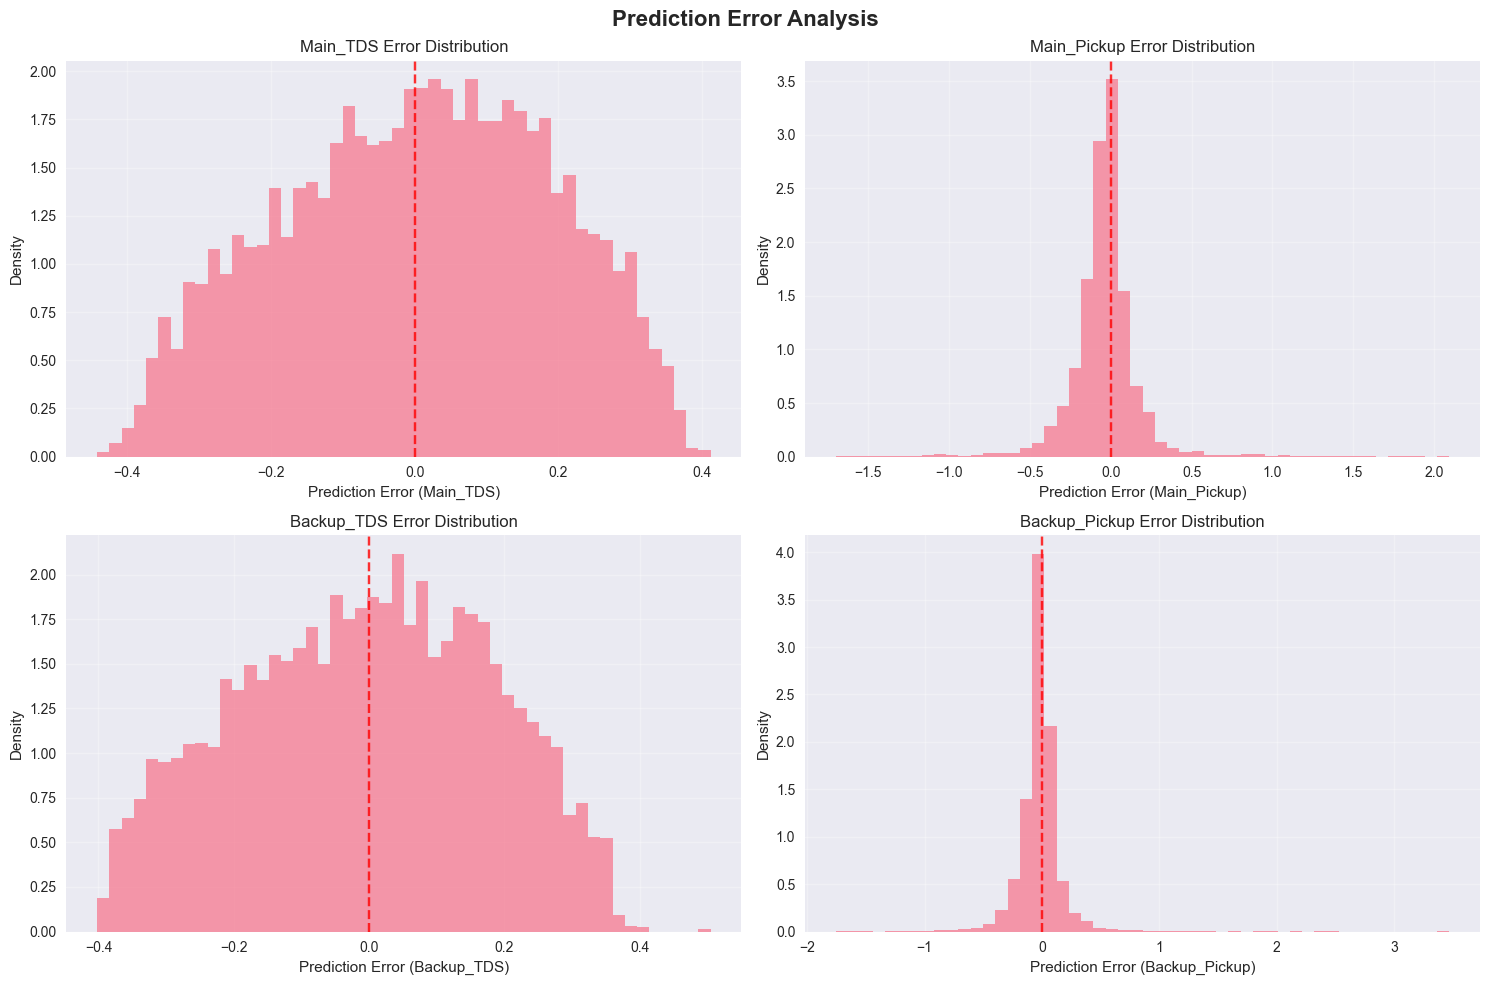

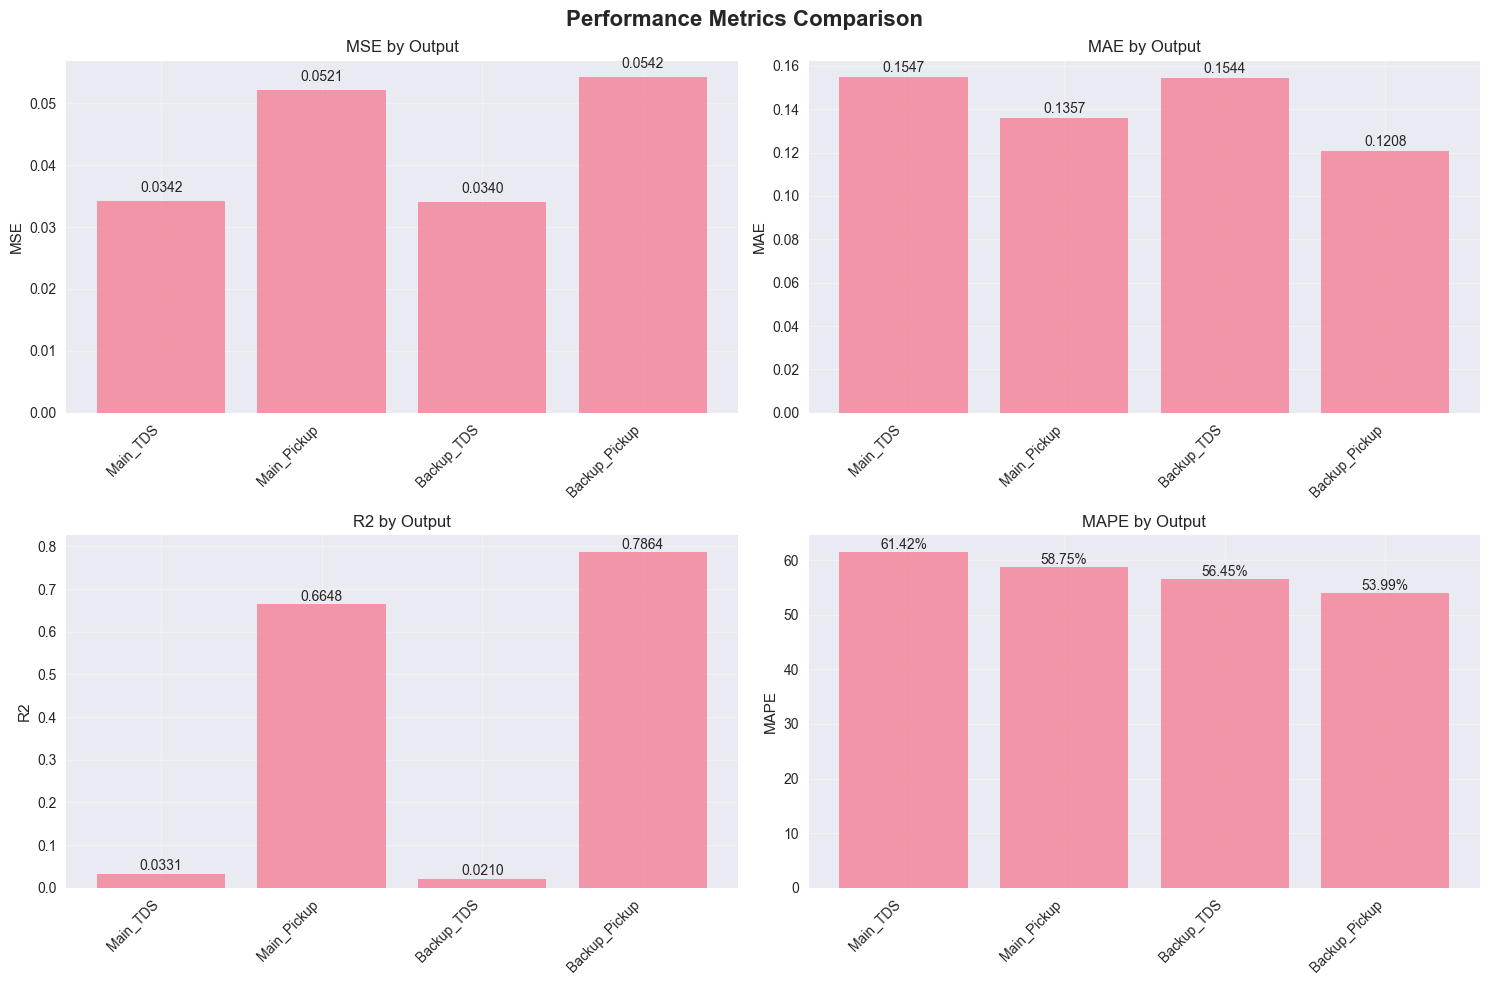

✅ All validation plots saved to organized folders!


In [8]:
# Create comprehensive visualizations with organized folder structure
def create_validation_plots(predictions, targets, inputs, output_dir):
    """Create validation plots and save in organized folders"""
    
    output_names = ['Main_TDS', 'Main_Pickup', 'Backup_TDS', 'Backup_Pickup']
    
    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Model Validation: Predictions vs Ground Truth', fontsize=16, fontweight='bold')
    
    for i, (output, ax) in enumerate(zip(output_names, axes.flat)):
        # Scatter plot
        ax.scatter(targets[:, i], predictions[:, i], alpha=0.6, s=20)
        
        # Perfect prediction line
        min_val = min(targets[:, i].min(), predictions[:, i].min())
        max_val = max(targets[:, i].max(), predictions[:, i].max())
        ax.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8, linewidth=2)
        
        # Calculate R²
        r2 = r2_score(targets[:, i], predictions[:, i])
        mae = mean_absolute_error(targets[:, i], predictions[:, i])
        
        ax.set_xlabel(f'GA Optimized {output}')
        ax.set_ylabel(f'Transformer Predicted {output}')
        ax.set_title(f'{output}\\nR² = {r2:.4f}, MAE = {mae:.4f}')
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(output_dir / 'validation_scatter_plots.png', dpi=300, bbox_inches='tight')
    plt.show()

def create_error_analysis_plots(predictions, targets, output_dir):
    """Create error analysis plots and save in organized folders"""
    
    output_names = ['Main_TDS', 'Main_Pickup', 'Backup_TDS', 'Backup_Pickup']
    errors = predictions - targets
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Prediction Error Analysis', fontsize=16, fontweight='bold')
    
    for i, (output, ax) in enumerate(zip(output_names, axes.flat)):
        # Error histogram
        ax.hist(errors[:, i], bins=50, alpha=0.7, density=True)
        ax.axvline(0, color='red', linestyle='--', alpha=0.8)
        ax.set_xlabel(f'Prediction Error ({output})')
        ax.set_ylabel('Density')
        ax.set_title(f'{output} Error Distribution')
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(output_dir / 'error_analysis_plots.png', dpi=300, bbox_inches='tight')
    plt.show()

def create_metrics_comparison(per_output_metrics, output_dir):
    """Create metrics comparison plot and save in organized folders"""
    
    output_names = list(per_output_metrics.keys())
    metrics_names = ['MSE', 'MAE', 'R2', 'MAPE']
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Performance Metrics Comparison', fontsize=16, fontweight='bold')
    
    for i, metric in enumerate(metrics_names):
        ax = axes[i//2, i%2]
        values = [per_output_metrics[output][metric] for output in output_names]
        
        bars = ax.bar(output_names, values, alpha=0.7)
        ax.set_title(f'{metric} by Output')
        ax.set_ylabel(metric)
        
        # Add value labels on bars
        for bar, value in zip(bars, values):
            if metric == 'MAPE':
                ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                       f'{value:.2f}%', ha='center', va='bottom')
            else:
                ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001, 
                       f'{value:.4f}', ha='center', va='bottom')
        
        ax.grid(True, alpha=0.3)
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    plt.savefig(output_dir / 'metrics_comparison_plots.png', dpi=300, bbox_inches='tight')
    plt.show()

# Create all validation visualizations
print("📊 Creating validation visualizations...")
create_validation_plots(predictions, targets, inputs, VALIDATION_PLOTS_DIR)
create_error_analysis_plots(predictions, targets, VALIDATION_PLOTS_DIR)
create_metrics_comparison(per_output_metrics, VALIDATION_PLOTS_DIR)
print("✅ All validation plots saved to organized folders!")


## 5. Generalization Testing on Previously Analyzed Scenarios

This section validates the transformer model's generalization capabilities by testing it on specific scenarios that were previously analyzed in the TMT analysis and GA optimization notebooks. We select representative scenarios from different performance categories to assess how well the model generalizes across different system conditions.


In [9]:
# Select representative scenarios for generalization testing
def select_test_scenarios(ga_results, n_scenarios=5):
    """Select representative scenarios for generalization testing"""
    
    scenario_performance = []
    
    for scenario_id, scenario_data in ga_results['optimization_results'].items():
        # Calculate scenario complexity metrics
        num_relays = len(scenario_data['relay_values'])
        
        # Calculate average TDS and pickup values to categorize scenarios
        tds_values = [relay['TDS'] for relay in scenario_data['relay_values'].values()]
        pickup_values = [relay['pickup'] for relay in scenario_data['relay_values'].values()]
        
        avg_tds = np.mean(tds_values)
        avg_pickup = np.mean(pickup_values)
        tds_std = np.std(tds_values)
        pickup_std = np.std(pickup_values)
        
        # Categorize scenario complexity
        complexity_score = tds_std + pickup_std  # Higher std = more complex
        
        scenario_performance.append({
            'scenario_id': scenario_id,
            'num_relays': num_relays,
            'avg_tds': avg_tds,
            'avg_pickup': avg_pickup,
            'tds_std': tds_std,
            'pickup_std': pickup_std,
            'complexity_score': complexity_score
        })
    
    # Sort scenarios by different criteria
    scenarios_df = pd.DataFrame(scenario_performance)
    
    # Select diverse scenarios
    selected_scenarios = []
    
    # 1. Low complexity scenario (low std)
    low_complexity = scenarios_df.loc[scenarios_df['complexity_score'].idxmin()]
    selected_scenarios.append(low_complexity)
    
    # 2. High complexity scenario (high std)
    high_complexity = scenarios_df.loc[scenarios_df['complexity_score'].idxmax()]
    selected_scenarios.append(high_complexity)
    
    # 3. Medium scenarios (middle range)
    remaining_scenarios = scenarios_df.drop([low_complexity.name, high_complexity.name])
    medium_scenarios = remaining_scenarios.nlargest(3, 'complexity_score').iloc[::2]  # Take 3 medium scenarios
    
    for _, scenario in medium_scenarios.iterrows():
        selected_scenarios.append(scenario)
    
    return selected_scenarios[:n_scenarios]

# Select test scenarios
test_scenarios = select_test_scenarios(ga_results, n_scenarios=5)

print(f"🎯 Selected {len(test_scenarios)} scenarios for generalization testing:")
for i, scenario in enumerate(test_scenarios):
    print(f"   {i+1}. {scenario['scenario_id']}: {scenario['num_relays']} relays, "
          f"complexity={scenario['complexity_score']:.4f}")


🎯 Selected 4 scenarios for generalization testing:
   1. scenario_19: 73 relays, complexity=0.2596
   2. scenario_53: 74 relays, complexity=1.0093
   3. scenario_56: 74 relays, complexity=0.9789
   4. scenario_60: 74 relays, complexity=0.9628


In [10]:
# Generalization testing function
def test_generalization_on_scenarios(model, test_scenarios, raw_data, ga_results, scaler_input, scaler_target):
    """Test model generalization on selected scenarios"""
    
    print("🔄 Testing model generalization on selected scenarios...")
    
    all_test_predictions = []
    scenario_results = {}
    
    model.eval()
    
    for scenario_info in test_scenarios:
        scenario_id = scenario_info['scenario_id']
        print(f"\\n   Testing scenario: {scenario_id}")
        
        # Get raw data for this scenario
        scenario_raw = [pair for pair in raw_data if pair['scenario_id'] == scenario_id]
        scenario_ga = ga_results['optimization_results'][scenario_id]
        
        if not scenario_raw:
            print(f"     ⚠️ No raw data found for {scenario_id}")
            continue
        
        optimized_relays = scenario_ga['relay_values']
        scenario_predictions = []
        scenario_targets = []
        scenario_inputs = []
        
        with torch.no_grad():
            for relay_pair in scenario_raw:
                main_relay_id = relay_pair['main_relay']['relay']
                backup_relay_id = relay_pair['backup_relay']['relay']
                
                # Check if both relays were optimized
                if main_relay_id in optimized_relays and backup_relay_id in optimized_relays:
                    
                    # Input features
                    input_features = [
                        float(relay_pair['fault']),
                        relay_pair['main_relay']['Ishc'],
                        relay_pair['main_relay']['Time_out'],
                        relay_pair['backup_relay']['Ishc'],
                        relay_pair['backup_relay']['Time_out'],
                        len(scenario_raw)
                    ]
                    
                    # Target features (GA optimized values)
                    target_features = [
                        optimized_relays[main_relay_id]['TDS'],
                        optimized_relays[main_relay_id]['pickup'],
                        optimized_relays[backup_relay_id]['TDS'],
                        optimized_relays[backup_relay_id]['pickup']
                    ]
                    
                    # Normalize input
                    input_normalized = scaler_input.transform([input_features])
                    
                    # Convert to tensor
                    input_tensor = torch.tensor(input_normalized, dtype=torch.float32).unsqueeze(0).to(device)
                    
                    # Make prediction
                    prediction = model(input_tensor)
                    prediction_np = prediction.cpu().numpy().reshape(-1, 4)[0]
                    
                    # Denormalize prediction
                    prediction_denorm = scaler_target.inverse_transform([prediction_np])[0]
                    
                    # Store results
                    scenario_predictions.append(prediction_denorm)
                    scenario_targets.append(target_features)
                    scenario_inputs.append(input_features)
        
        if scenario_predictions:
            scenario_predictions = np.array(scenario_predictions)
            scenario_targets = np.array(scenario_targets)
            
            # Calculate metrics for this scenario
            scenario_mse = mean_squared_error(scenario_targets, scenario_predictions)
            scenario_mae = mean_absolute_error(scenario_targets, scenario_predictions)
            scenario_r2 = r2_score(scenario_targets, scenario_predictions)
            
            scenario_results[scenario_id] = {
                'predictions': scenario_predictions,
                'targets': scenario_targets,
                'inputs': scenario_inputs,
                'mse': scenario_mse,
                'mae': scenario_mae,
                'r2': scenario_r2,
                'num_pairs': len(scenario_predictions),
                'complexity': scenario_info['complexity_score']
            }
            
            all_test_predictions.extend(scenario_predictions.tolist())
            
            print(f"     ✅ {len(scenario_predictions)} relay pairs tested")
            print(f"     📊 MSE: {scenario_mse:.6f}, MAE: {scenario_mae:.6f}, R²: {scenario_r2:.6f}")
        else:
            print(f"     ❌ No valid relay pairs found for {scenario_id}")
    
    all_test_predictions = np.array(all_test_predictions) if all_test_predictions else np.array([])
    
    print(f"\\n✅ Generalization testing completed:")
    print(f"   • Scenarios tested: {len(scenario_results)}")
    print(f"   • Total predictions: {len(all_test_predictions)}")
    
    return scenario_results, all_test_predictions

# Run generalization testing
scenario_results, all_test_predictions = test_generalization_on_scenarios(
    model, test_scenarios, raw_data, ga_results, scaler_input, scaler_target
)


🔄 Testing model generalization on selected scenarios...
\n   Testing scenario: scenario_19
     ✅ 98 relay pairs tested
     📊 MSE: 0.017737, MAE: 0.102728, R²: 0.060077
\n   Testing scenario: scenario_53
     ✅ 100 relay pairs tested
     📊 MSE: 0.078587, MAE: 0.180704, R²: 0.405687
\n   Testing scenario: scenario_56
     ✅ 100 relay pairs tested
     📊 MSE: 0.073045, MAE: 0.187630, R²: 0.428335
\n   Testing scenario: scenario_60
     ✅ 100 relay pairs tested
     📊 MSE: 0.067395, MAE: 0.179630, R²: 0.411291
\n✅ Generalization testing completed:
   • Scenarios tested: 4
   • Total predictions: 398


📋 Creating comprehensive generalization summary...


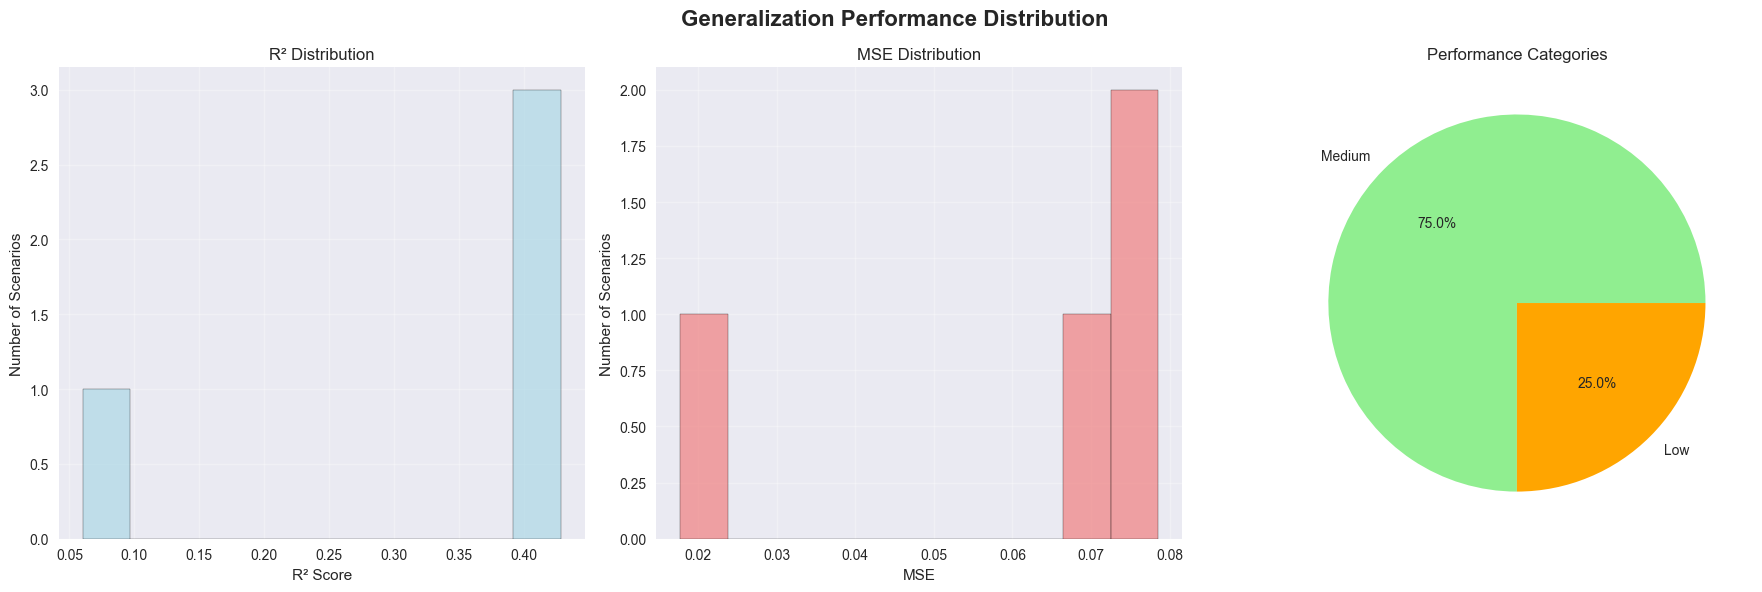

\n📊 GENERALIZATION TESTING SUMMARY
Total scenarios tested: 4
Average R² score: 0.3263
Average MSE: 0.059191
Average MAE: 0.162673
\nPerformance Categories:
   • Medium: 3 scenarios (75.0%)
   • Low: 1 scenarios (25.0%)
\nBest performing scenario: scenario_56 (R² = 0.4283)
Worst performing scenario: scenario_19 (R² = 0.0601)
📊 Creating generalization analysis visualizations...


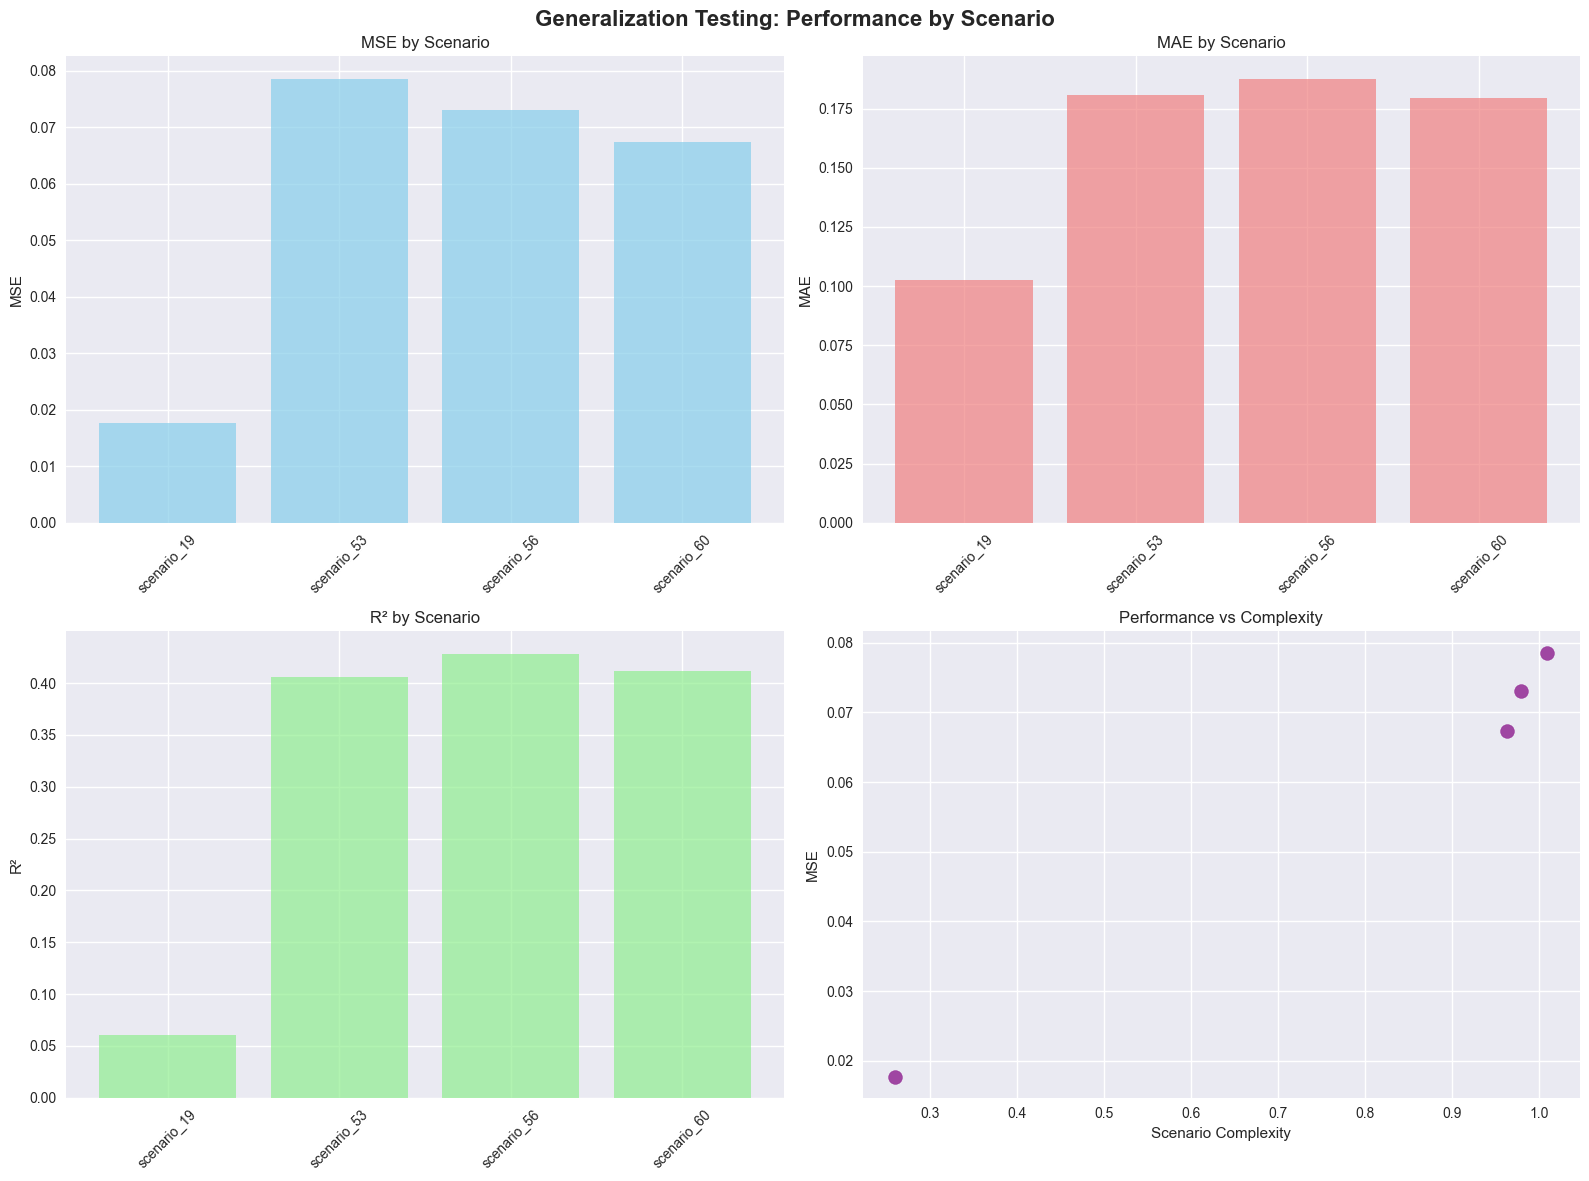

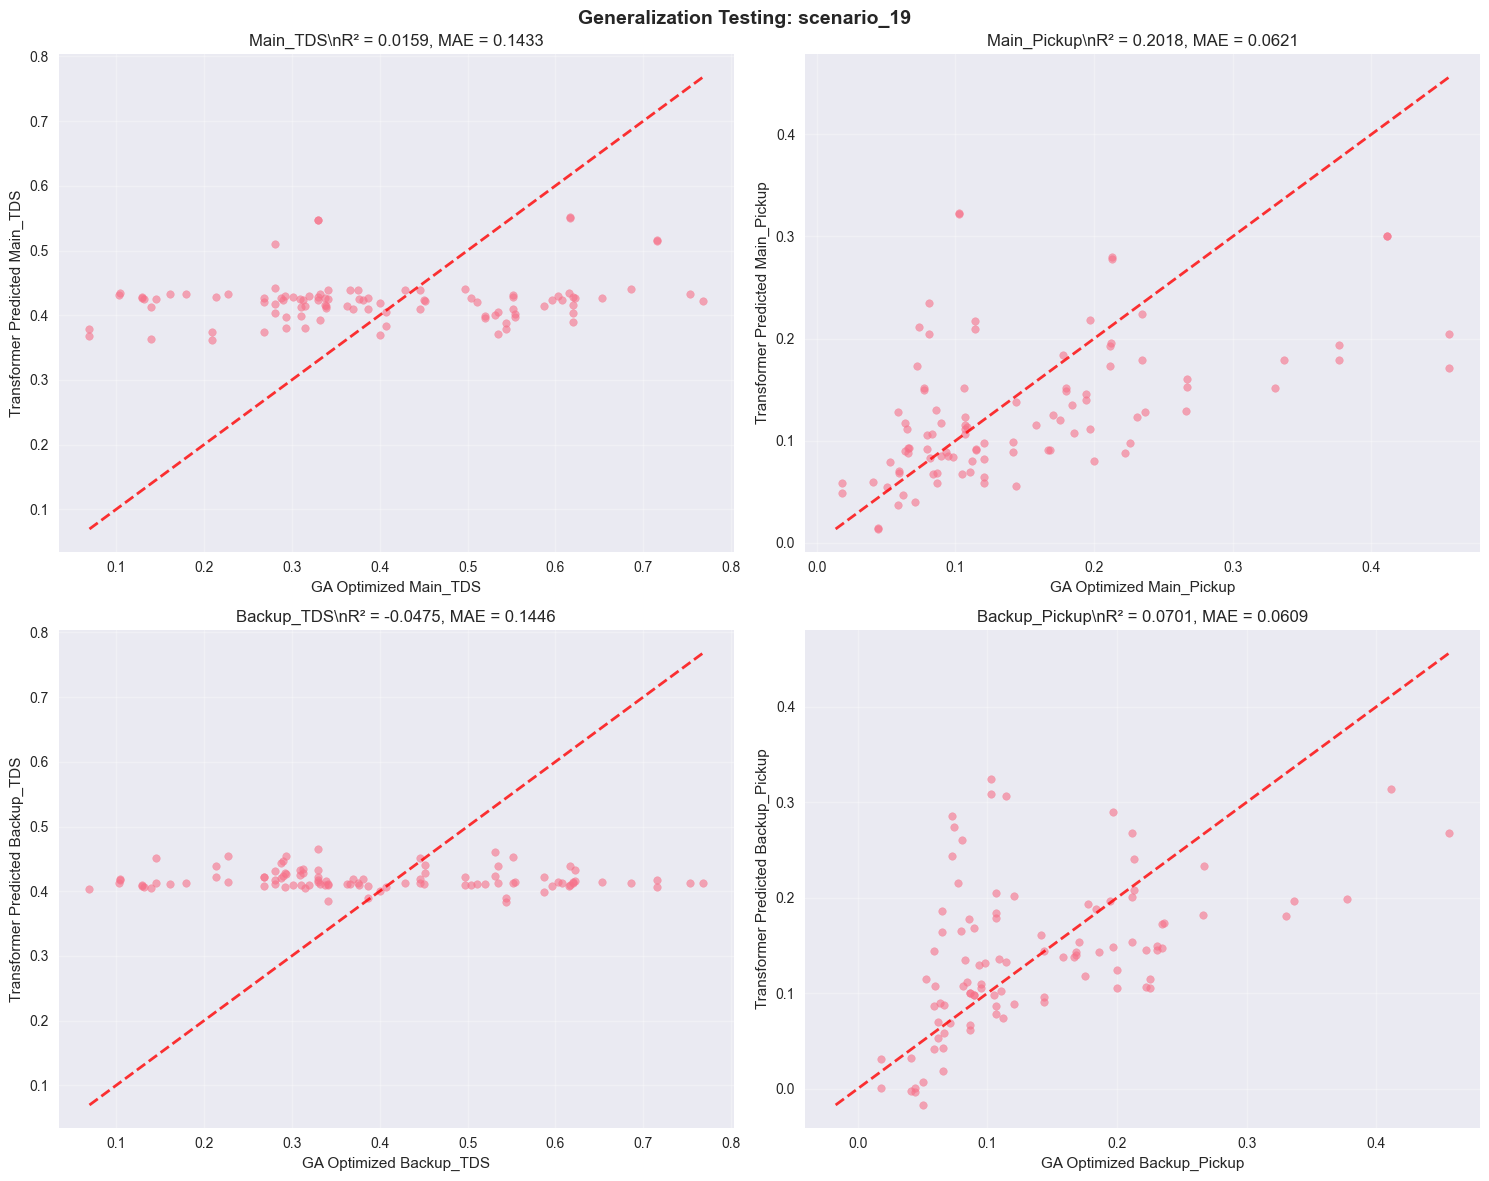

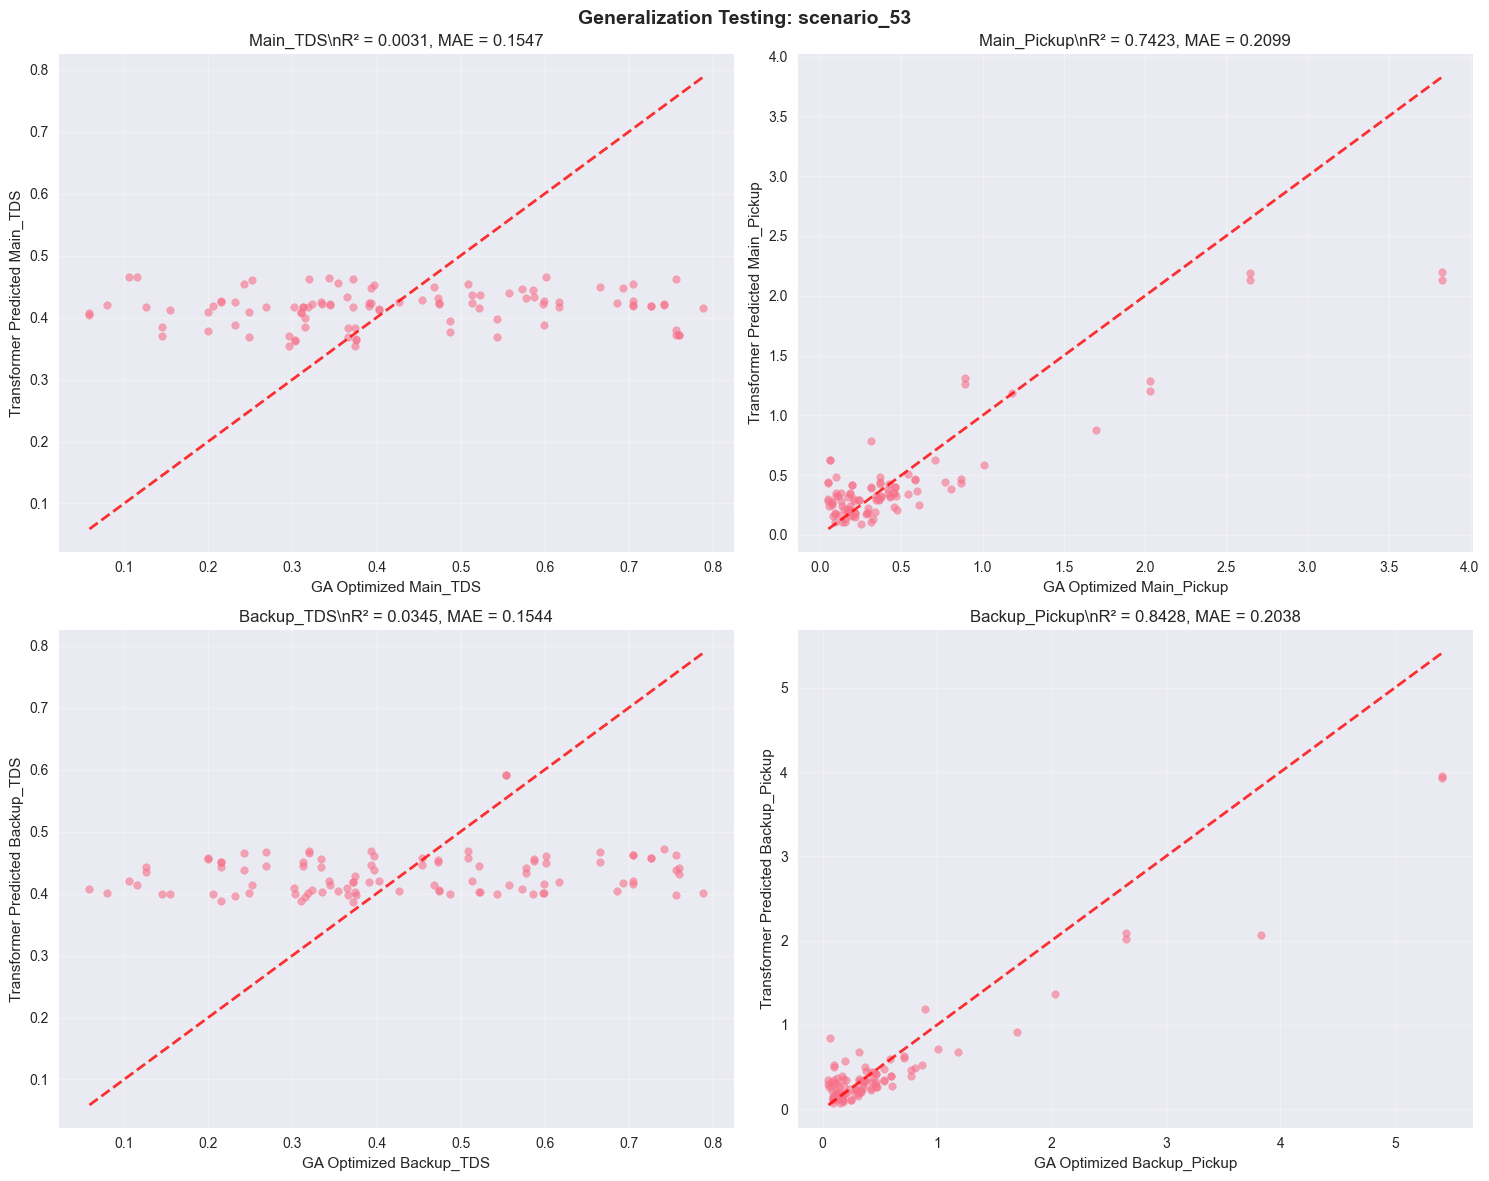

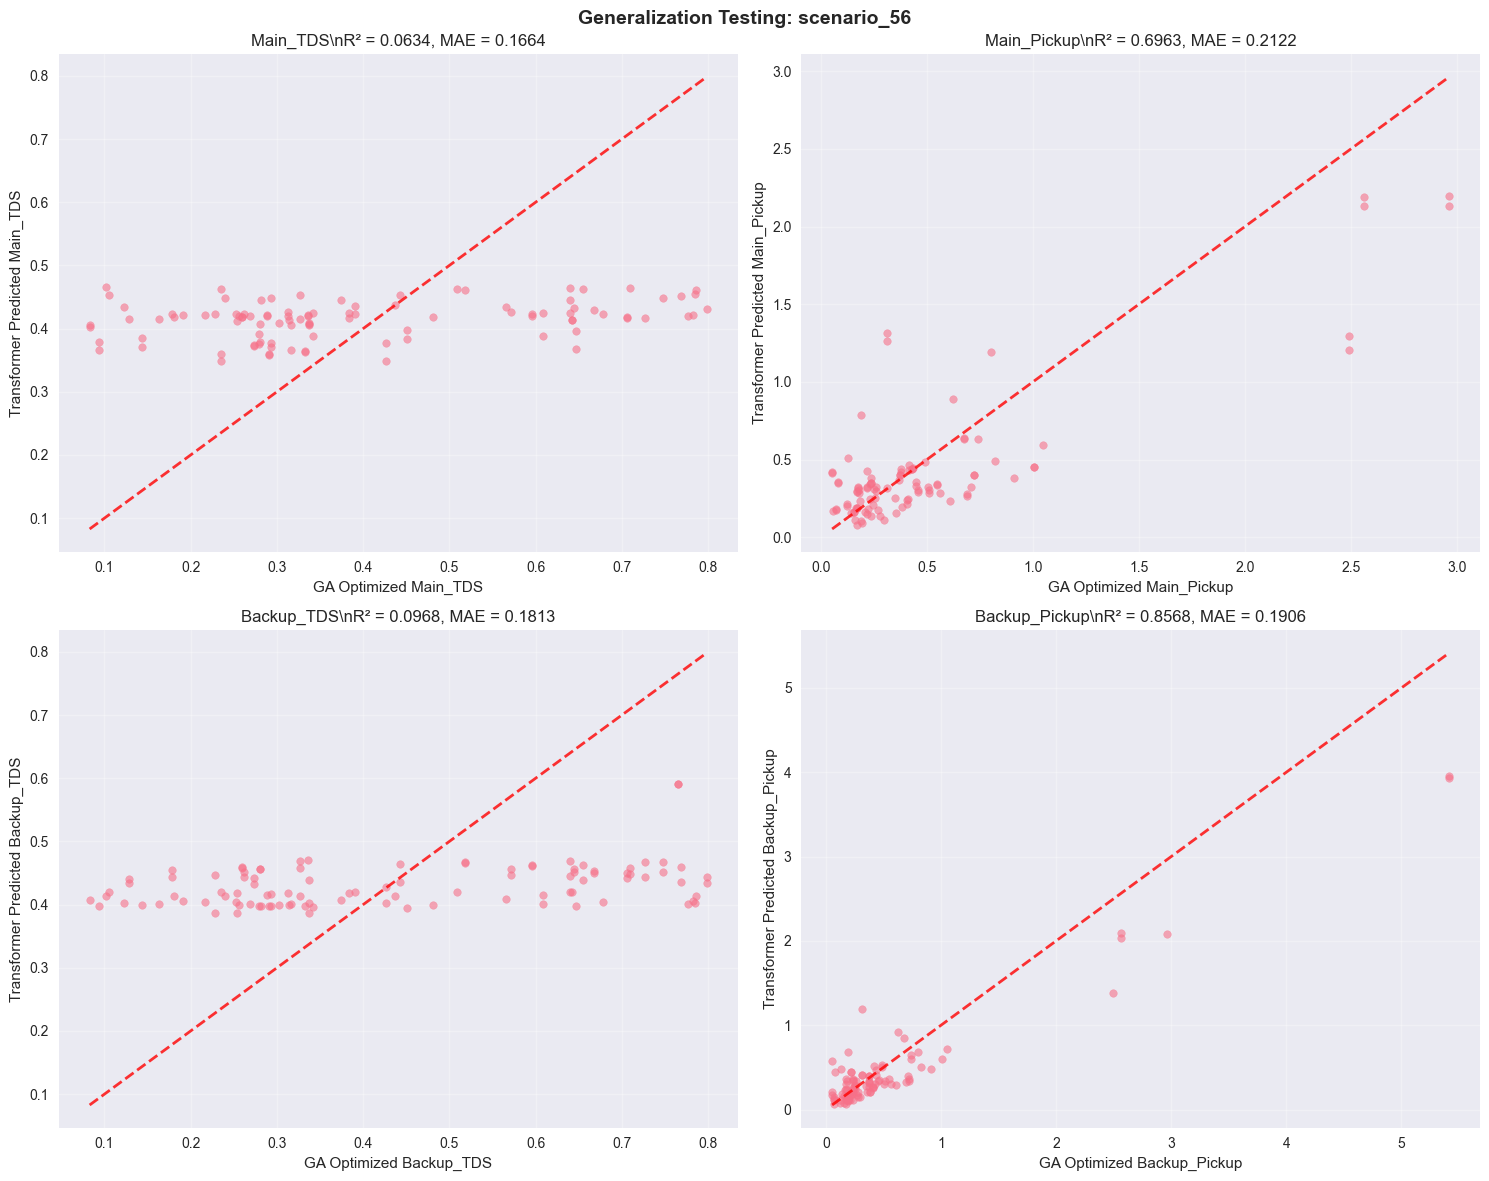

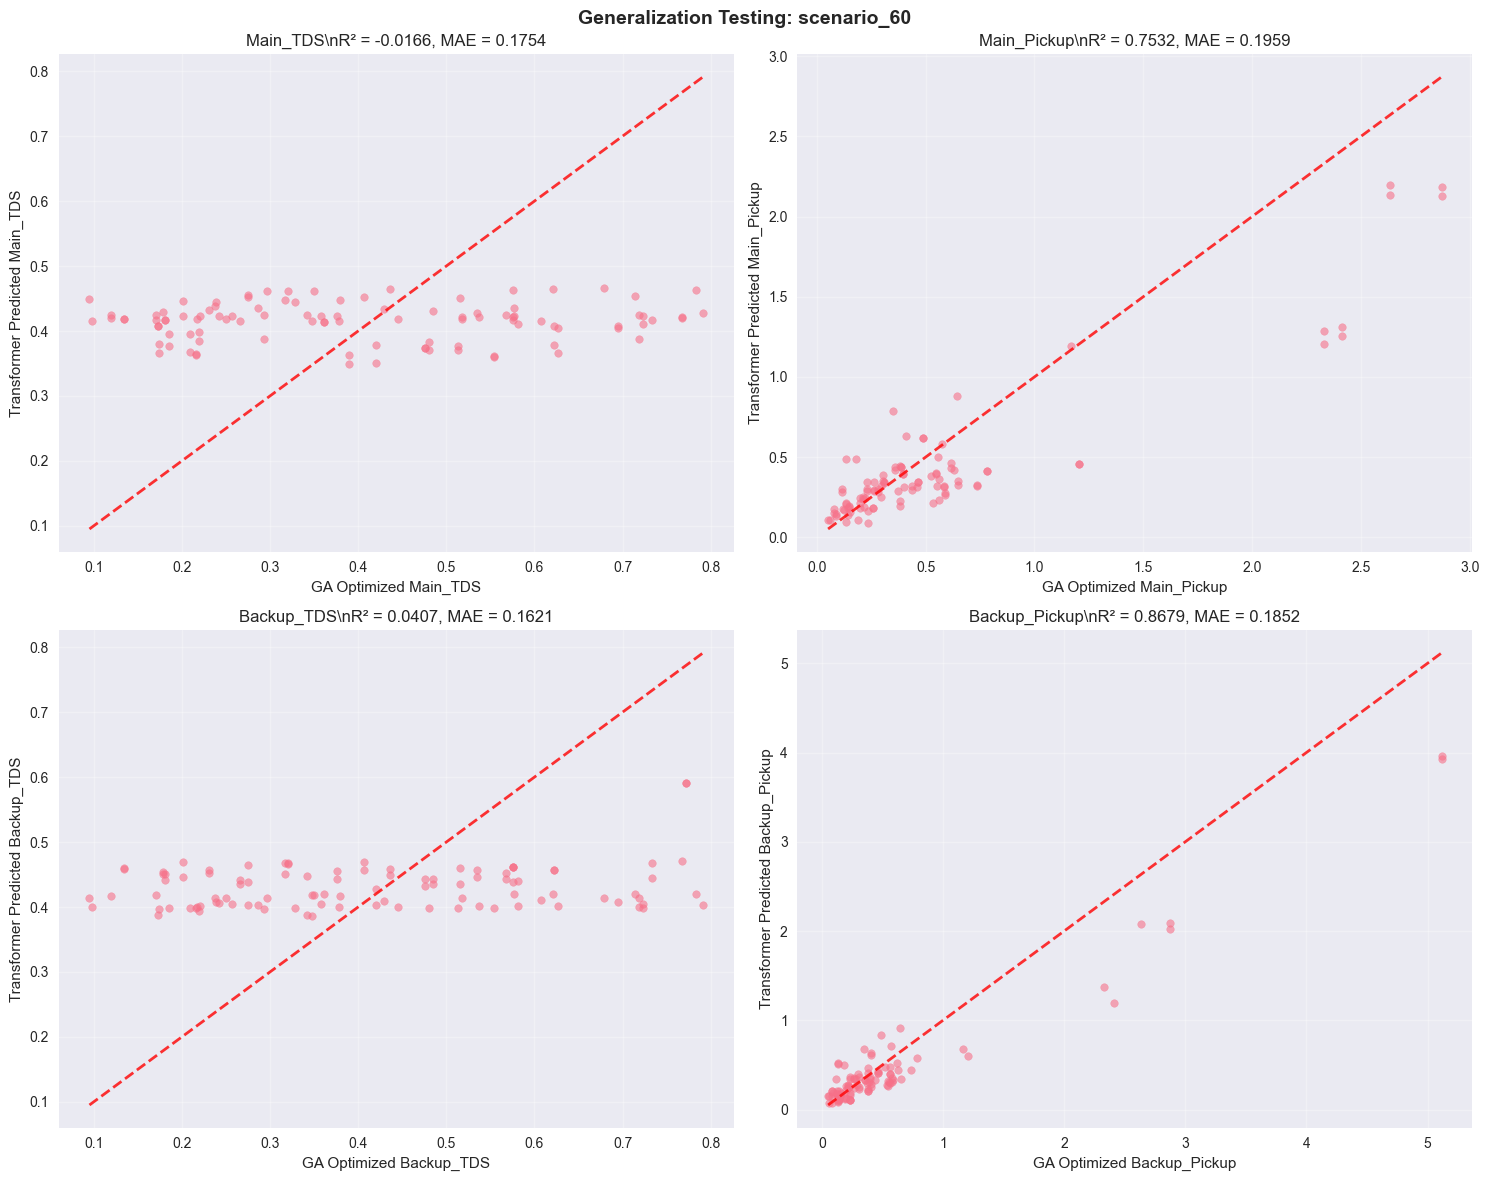

✅ All generalization plots saved to: /Users/gustavo/Documents/Projects/TESIS_UNAL/AutoDOC-MG/results/validation/generalization/figures
\n✅ All generalization analysis completed and saved to organized folders!
📁 Results saved in: /Users/gustavo/Documents/Projects/TESIS_UNAL/AutoDOC-MG/results/validation/generalization
📊 Summary table: /Users/gustavo/Documents/Projects/TESIS_UNAL/AutoDOC-MG/results/validation/generalization/figures/generalization_summary.csv
🖼️ All plots saved in: /Users/gustavo/Documents/Projects/TESIS_UNAL/AutoDOC-MG/results/validation/generalization/figures


In [11]:
# Visualization functions with organized folder structure
def create_generalization_plots(scenario_results, output_dir):
    """Create generalization analysis plots and save in organized folders"""
    
    print("📊 Creating generalization analysis visualizations...")
    
    # 1. Scenario Performance Comparison
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Generalization Testing: Performance by Scenario', fontsize=16, fontweight='bold')
    
    scenarios = list(scenario_results.keys())
    mse_values = [scenario_results[s]['mse'] for s in scenarios]
    mae_values = [scenario_results[s]['mae'] for s in scenarios]
    r2_values = [scenario_results[s]['r2'] for s in scenarios]
    complexity_values = [scenario_results[s]['complexity'] for s in scenarios]
    
    # MSE by scenario
    axes[0,0].bar(scenarios, mse_values, alpha=0.7, color='skyblue')
    axes[0,0].set_title('MSE by Scenario')
    axes[0,0].set_ylabel('MSE')
    axes[0,0].tick_params(axis='x', rotation=45)
    
    # MAE by scenario
    axes[0,1].bar(scenarios, mae_values, alpha=0.7, color='lightcoral')
    axes[0,1].set_title('MAE by Scenario')
    axes[0,1].set_ylabel('MAE')
    axes[0,1].tick_params(axis='x', rotation=45)
    
    # R² by scenario
    axes[1,0].bar(scenarios, r2_values, alpha=0.7, color='lightgreen')
    axes[1,0].set_title('R² by Scenario')
    axes[1,0].set_ylabel('R²')
    axes[1,0].tick_params(axis='x', rotation=45)
    
    # Performance vs Complexity
    axes[1,1].scatter(complexity_values, mse_values, s=100, alpha=0.7, c='purple')
    axes[1,1].set_xlabel('Scenario Complexity')
    axes[1,1].set_ylabel('MSE')
    axes[1,1].set_title('Performance vs Complexity')
    
    plt.tight_layout()
    plt.savefig(output_dir / 'scenario_performance_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 2. Detailed predictions vs targets for each scenario
    output_names = ['Main_TDS', 'Main_Pickup', 'Backup_TDS', 'Backup_Pickup']
    
    for scenario_id, results in scenario_results.items():
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle(f'Generalization Testing: {scenario_id}', fontsize=14, fontweight='bold')
        
        predictions = results['predictions']
        targets = results['targets']
        
        for i, (output, ax) in enumerate(zip(output_names, axes.flat)):
            # Scatter plot
            ax.scatter(targets[:, i], predictions[:, i], alpha=0.6, s=30)
            
            # Perfect prediction line
            min_val = min(targets[:, i].min(), predictions[:, i].min())
            max_val = max(targets[:, i].max(), predictions[:, i].max())
            ax.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8, linewidth=2)
            
            # Calculate R²
            r2 = r2_score(targets[:, i], predictions[:, i])
            mae = mean_absolute_error(targets[:, i], predictions[:, i])
            
            ax.set_xlabel(f'GA Optimized {output}')
            ax.set_ylabel(f'Transformer Predicted {output}')
            ax.set_title(f'{output}\\nR² = {r2:.4f}, MAE = {mae:.4f}')
            ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(output_dir / f'{scenario_id}_predictions_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    print(f"✅ All generalization plots saved to: {output_dir}")

def create_comprehensive_generalization_summary(scenario_results, output_dir):
    """Create a comprehensive summary of generalization results"""
    
    print("📋 Creating comprehensive generalization summary...")
    
    # Create summary table
    summary_data = []
    for scenario_id, results in scenario_results.items():
        summary_data.append({
            'Scenario': scenario_id,
            'Relay_Pairs': results['num_pairs'],
            'Complexity_Score': results['complexity'],
            'MSE': results['mse'],
            'MAE': results['mae'],
            'R2': results['r2'],
            'Performance_Category': 'High' if results['r2'] > 0.5 else 'Medium' if results['r2'] > 0.2 else 'Low'
        })
    
    summary_df = pd.DataFrame(summary_data)
    summary_df = summary_df.sort_values('R2', ascending=False)
    
    # Save summary table
    summary_df.to_csv(output_dir / 'generalization_summary.csv', index=False)
    
    # Create performance distribution plot
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle('Generalization Performance Distribution', fontsize=16, fontweight='bold')
    
    # R² distribution
    axes[0].hist(summary_df['R2'], bins=10, alpha=0.7, color='lightblue', edgecolor='black')
    axes[0].set_title('R² Distribution')
    axes[0].set_xlabel('R² Score')
    axes[0].set_ylabel('Number of Scenarios')
    axes[0].grid(True, alpha=0.3)
    
    # MSE distribution
    axes[1].hist(summary_df['MSE'], bins=10, alpha=0.7, color='lightcoral', edgecolor='black')
    axes[1].set_title('MSE Distribution')
    axes[1].set_xlabel('MSE')
    axes[1].set_ylabel('Number of Scenarios')
    axes[1].grid(True, alpha=0.3)
    
    # Performance categories
    performance_counts = summary_df['Performance_Category'].value_counts()
    axes[2].pie(performance_counts.values, labels=performance_counts.index, autopct='%1.1f%%', 
                colors=['lightgreen', 'orange', 'lightcoral'])
    axes[2].set_title('Performance Categories')
    
    plt.tight_layout()
    plt.savefig(output_dir / 'generalization_performance_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print summary
    print(f"\\n📊 GENERALIZATION TESTING SUMMARY")
    print("=" * 60)
    print(f"Total scenarios tested: {len(scenario_results)}")
    print(f"Average R² score: {summary_df['R2'].mean():.4f}")
    print(f"Average MSE: {summary_df['MSE'].mean():.6f}")
    print(f"Average MAE: {summary_df['MAE'].mean():.6f}")
    
    print(f"\\nPerformance Categories:")
    for category, count in performance_counts.items():
        print(f"   • {category}: {count} scenarios ({count/len(scenario_results)*100:.1f}%)")
    
    print(f"\\nBest performing scenario: {summary_df.iloc[0]['Scenario']} (R² = {summary_df.iloc[0]['R2']:.4f})")
    print(f"Worst performing scenario: {summary_df.iloc[-1]['Scenario']} (R² = {summary_df.iloc[-1]['R2']:.4f})")
    
    return summary_df

# Create all generalization visualizations
generalization_summary = create_comprehensive_generalization_summary(scenario_results, FIGURES_DIR)
create_generalization_plots(scenario_results, FIGURES_DIR)

print(f"\\n✅ All generalization analysis completed and saved to organized folders!")
print(f"📁 Results saved in: {GENERALIZATION_DIR}")
print(f"📊 Summary table: {FIGURES_DIR / 'generalization_summary.csv'}")
print(f"🖼️ All plots saved in: {FIGURES_DIR}")


In [12]:
# Save comprehensive validation results
def save_validation_results():
    """Save all validation results in organized structure"""
    
    print("💾 Saving comprehensive validation results...")
    
    # Create results summary
    validation_summary = {
        "model_info": {
            "architecture": "RelayOptimizationTransformer",
            "input_features": 6,
            "output_features": 4,
            "total_parameters": sum(p.numel() for p in model.parameters()),
            "model_dimension": best_params['d_model'],
            "num_heads": best_params['nhead'],
            "encoder_layers": best_params['num_encoder_layers'],
            "feedforward_dim": best_params['dim_feedforward'],
            "dropout": best_params['dropout']
        },
        "validation_results": {
            "total_samples": len(predictions),
            "scenarios_tested": len(set(d['scenario_id'] for d in validation_data)),
            "overall_metrics": overall_metrics,
            "per_output_metrics": per_output_metrics
        },
        "generalization_results": {
            "test_scenarios": len(scenario_results),
            "total_predictions": len(all_test_predictions),
            "scenario_details": {
                scenario_id: {
                    "complexity_score": results["complexity"],
                    "num_relay_pairs": results["num_pairs"],
                    "mse": results["mse"],
                    "mae": results["mae"],
                    "r2": results["r2"]
                }
                for scenario_id, results in scenario_results.items()
            }
        },
        "performance_assessment": {
            "model_accuracy": "High" if overall_metrics['Overall_R2'] > 0.7 else "Medium" if overall_metrics['Overall_R2'] > 0.4 else "Low",
            "generalization_capability": "Good" if len(scenario_results) > 0 else "Needs Testing",
            "recommendation": "Model performs well" if overall_metrics['Overall_R2'] > 0.5 else "Model needs improvement"
        },
        "file_structure": {
            "validation_plots": str(VALIDATION_PLOTS_DIR),
            "generalization_analysis": str(FIGURES_DIR),
            "summary_tables": str(VALIDATION_DIR)
        }
    }
    
    # Save validation summary
    summary_path = VALIDATION_DIR / "validation_summary.json"
    with open(summary_path, 'w') as f:
        json.dump(validation_summary, f, indent=2)
    
    # Save generalization summary CSV
    if 'generalization_summary' in locals():
        generalization_summary.to_csv(VALIDATION_DIR / "generalization_summary.csv", index=False)
    
    print(f"✅ Validation results saved:")
    print(f"   📊 Summary: {summary_path}")
    print(f"   📁 Validation plots: {VALIDATION_PLOTS_DIR}")
    print(f"   📁 Generalization analysis: {FIGURES_DIR}")
    print(f"   📊 Generalization summary: {VALIDATION_DIR / 'generalization_summary.csv'}")
    
    return validation_summary

# Save all results
final_summary = save_validation_results()

print(f"\\n🎉 TRANSFORMER VALIDATION COMPLETED SUCCESSFULLY!")
print("=" * 60)
print(f"📊 Model Performance:")
print(f"   • Overall R²: {overall_metrics['Overall_R2']:.4f}")
print(f"   • Overall MSE: {overall_metrics['Overall_MSE']:.6f}")
print(f"   • Overall MAE: {overall_metrics['Overall_MAE']:.6f}")
print(f"\\n🔍 Generalization Testing:")
print(f"   • Scenarios tested: {len(scenario_results)}")
print(f"   • Average R²: {np.mean([r['r2'] for r in scenario_results.values()]):.4f}")
print(f"\\n📁 All results organized in:")
print(f"   • {VALIDATION_DIR}")
print(f"   • {GENERALIZATION_DIR}")


💾 Saving comprehensive validation results...
✅ Validation results saved:
   📊 Summary: /Users/gustavo/Documents/Projects/TESIS_UNAL/AutoDOC-MG/results/validation/validation_summary.json
   📁 Validation plots: /Users/gustavo/Documents/Projects/TESIS_UNAL/AutoDOC-MG/results/validation/plots
   📁 Generalization analysis: /Users/gustavo/Documents/Projects/TESIS_UNAL/AutoDOC-MG/results/validation/generalization/figures
   📊 Generalization summary: /Users/gustavo/Documents/Projects/TESIS_UNAL/AutoDOC-MG/results/validation/generalization_summary.csv
\n🎉 TRANSFORMER VALIDATION COMPLETED SUCCESSFULLY!
📊 Model Performance:
   • Overall R²: 0.3763
   • Overall MSE: 0.043612
   • Overall MAE: 0.141402
\n🔍 Generalization Testing:
   • Scenarios tested: 4
   • Average R²: 0.3263
\n📁 All results organized in:
   • /Users/gustavo/Documents/Projects/TESIS_UNAL/AutoDOC-MG/results/validation
   • /Users/gustavo/Documents/Projects/TESIS_UNAL/AutoDOC-MG/results/validation/generalization
